In [1]:
from Preprocess_EDA import *

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from tqdm import tqdm

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stp = set(stopwords.words('english'))
add_stp = ['com', 'www', 'http', 'video', 'short', 'de', 'youtube', 'tiktok']
for w in add_stp:
    stp.add(w)

[nltk_data] Downloading package stopwords to /Users/wei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/wei/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/wei/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# remove emoji
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

# remove URLs, white space, special characters
def text_preprocess(text):
    text = ''.join([i for i in text if not i.isdigit()]) # remove digits
    text = text.lower() # lowercase each word
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # remove special characters
    text = re.sub(r'http\S+', '', text) # remove urls
    text = emoji_pattern.sub(r'', text) # remove emojis
    return text.strip()

# introduce stopwords to filter out common words such as: the, being, over...                                                           
def remove_stopwords(text):
    return [word for word in text if word not in stp]

# Lemmatization: converting a word to its base form
lemma = nltk.wordnet.WordNetLemmatizer()
def lemmatization(text):
    lst = [lemma.lemmatize(w.strip()) for w in text.split()]
    return set(lst)

# flatten list
def flatten(t):
    return [item for sublist in t for item in sublist]

In [3]:
# input cat should be a list, eg: ['Entertainment']
def select_category(cat):
    # read data
    df = integrate_clean_data()
    # subset data for text columns
    df_s = df[['video_id', 'categoryId', 'category', 'title', 'tags', 'description']]
    # drop duplicate
    data = df_s.drop_duplicates(subset = ['video_id'], keep = 'first')
    # select the category
    df_cat = data[data['category'].isin(cat)]
    return df_cat

# take mean of all the word vectors in a sentence
def avgw2v(list_of_sent, w2v_model, w2v_words):
    sent_vectors = []; 
    for sent in tqdm(list_of_sent):
        sent_vec = np.zeros(50)
        cnt_words =0; 
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    print(len(sent_vectors))
    print(len(sent_vectors[0]))
    return sent_vectors

# use elbow method on the graph to select optimum cluster number
def k_means_evaluate(data, k):
    models = []
    loss = []
    for i in k:
        kmeans=KMeans(n_clusters = i,init = 'k-means++', random_state = 2, 
                     algorithm = 'auto').fit(data)
        models.append(kmeans)
        loss.append(kmeans.inertia_) # Sum of squared distances of samples to their closest cluster center
    
    # plot using elbow method
    fig, ax = plt.subplots(figsize = (10, 6))
    ax = sns.lineplot(x = k, y = loss, markers = True)
    sns.set_style("whitegrid")
    plt.title('Elbow Method for the Selection of Optimal "K" Clusters', fontsize = 18)
    plt.xlabel('Number of Clusters', fontsize = 14)
    plt.ylabel('Loss', fontsize = 14)
    plt.show() 
    return models

# plot word cloud for each cluster
def cluster_analysis(df, k):
    #For each cluster
    for i in range(0, k):
        #Extract cleaned text column
        data = df[df['labels'] == i]['cleaned_text'].values
        list_of_words=[];
        for sent in data:
            for word in sent:
                list_of_words.append(word.strip())
        final_text=" ".join(list_of_words)
        wordcloud = WordCloud(collocations = True, width = 600, height = 600, 
                              background_color='white', 
                              colormap='tab10').generate(final_text)
        plt.figure()
        title = "\nCluster: " + str(i + 1) + "\nNumber of videos " + str(data.shape[0])
        plt.title(title)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

In [4]:
all_cat_list = ['Entertainment',
                 'People & Blogs',
                 'Science & Technology',
                 'Music',
                 'Education',
                 'Comedy',
                 'Gaming',
                 'Sports',
                 'Film & Animation',
                 'Autos & Vehicles',
                 'Howto & Style',
                 'Pets & Animals',
                 'News & Politics',
                 'Travel & Events',
                 'Nonprofits & Activism']

def main(category = all_cat_list, n_cluster = 4):
    # read data
    data = select_category(cat = category)
    print(data.shape)
    # print(data.head())

    # replace NaN values with an empty string
    data['tags'] = data['tags'].fillna(' ')
    data['description'] = data['description'].fillna(' ')

    # combine text features together: title, tags, description
    # channelTitle is not included, because there might be one channel title appears several times
    # data['text_com'] = data[['title', 'tags', 'description']].agg(' '.join, axis = 'columns')
    data['text_com'] = data[['title', 'tags']].agg(' '.join, axis = 'columns')

    # preprocess text, lemmatization, remove stopwords
    data['cleaned_text'] = data['text_com'].apply(text_preprocess)
    data['cleaned_text'] = data['cleaned_text'].apply(lemmatization)
    data['cleaned_text'] = data['cleaned_text'].apply(remove_stopwords)

    # convert words into list of lists
    cleaned_text = data['cleaned_text']
    list_text = []
    for set_item in cleaned_text.values:
        # remove single letter
        inner_list = [word.strip() for word in set_item if len(word.strip()) != 1]
        list_text.append(inner_list)

    # flatten inner list
    for lst in list_text:
        flatten(lst)

    # generating word embeddings using Word2Vec
    w2v_model = Word2Vec(list_text, vector_size = 50, min_count = 1, workers=4)
    w2v_words = list(w2v_model.wv.index_to_key)

    # take mean of all the word vectors in a sentence
    sent_vect = avgw2v(list_text, w2v_model, w2v_words)

    # standardize the data
    std = StandardScaler()
    data_vect = std.fit_transform(sent_vect)

    # draw the line plot with elbow method
    model_list = k_means_evaluate(data_vect, range(2, 15))

    # select n clusters
    data['labels'] = model_list[n_cluster - 2].labels_ 
    cluster_analysis(data, n_cluster)

(9461, 6)


100%|█████████████████████████████████████| 9461/9461 [00:04<00:00, 1902.41it/s]


9461
50


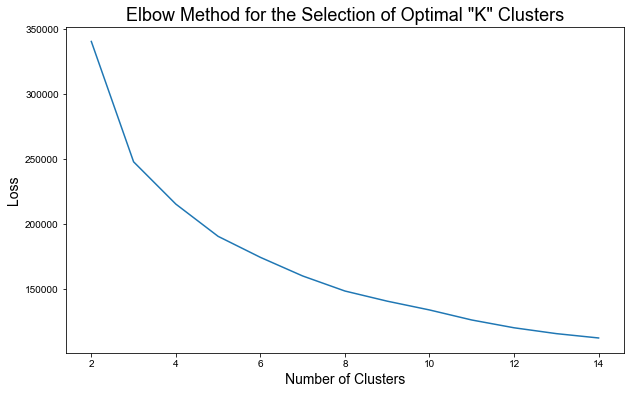

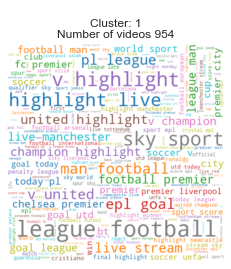

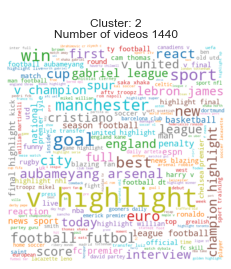

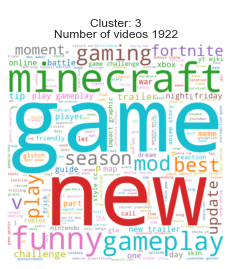

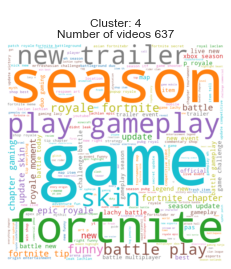

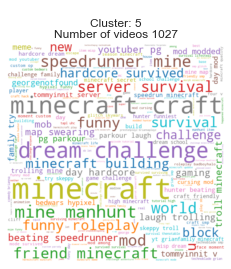

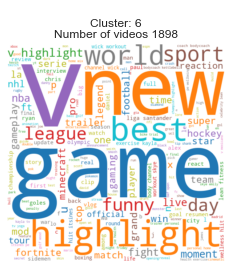

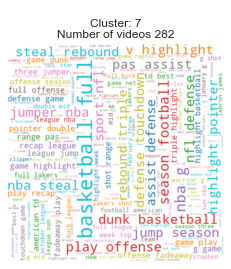

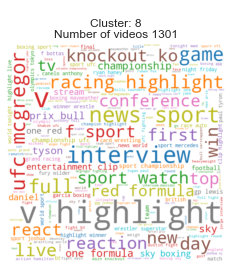

In [5]:
main(category = ['Gaming', 'Sports'], n_cluster = 8)

(27873, 6)


100%|████████████████████████████████████| 27873/27873 [00:28<00:00, 969.87it/s]


27873
50


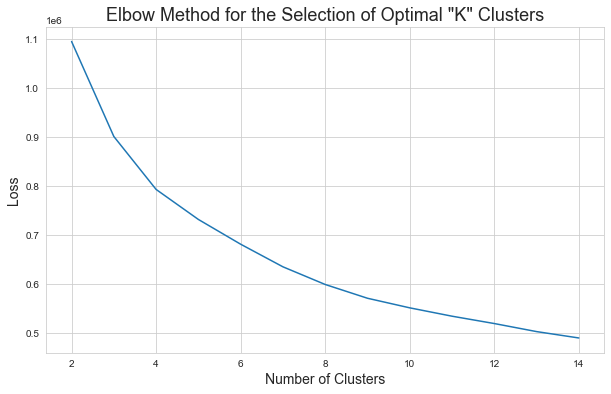

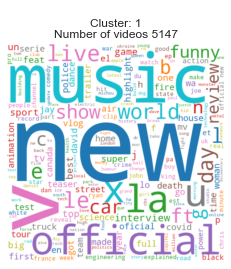

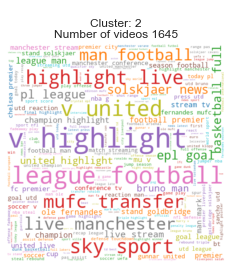

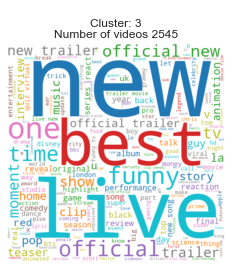

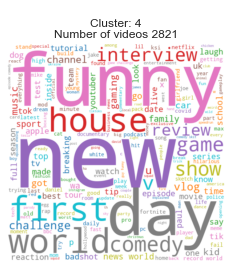

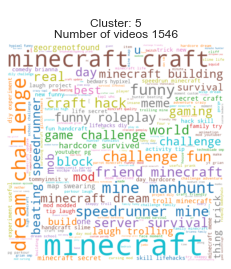

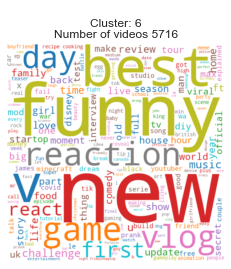

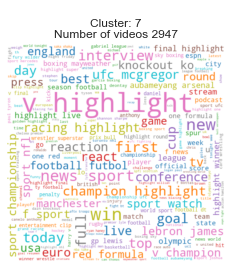

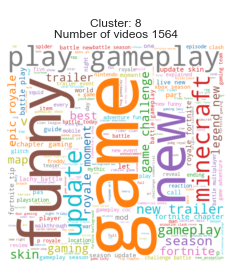

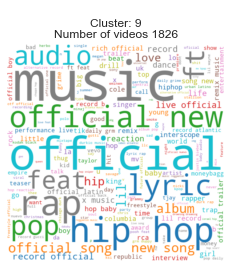

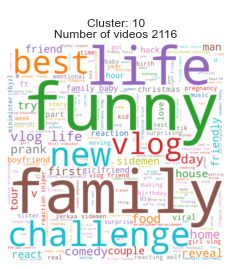

In [6]:
# all category
main(n_cluster = 10)

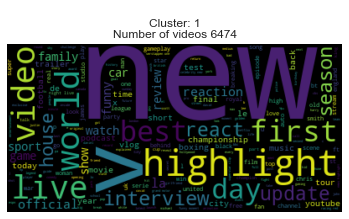

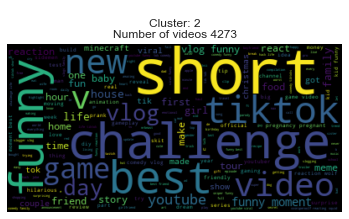

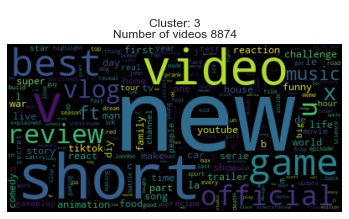

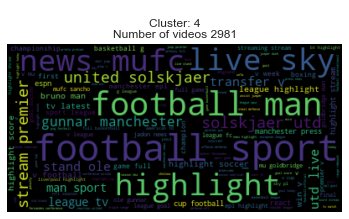

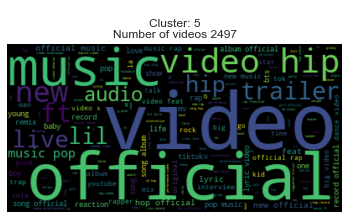

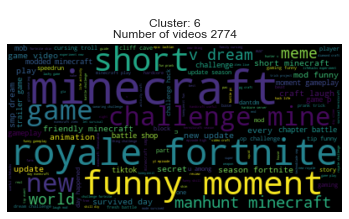

In [19]:
# all category
cluster_analysis(data, 6)